<a href="https://colab.research.google.com/github/cm180697/conda/blob/master/Categorical_Clustering_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

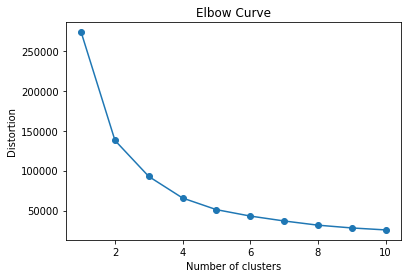

Silhouette score for 2 clusters: 0.46995335689896056
Silhouette score for 3 clusters: 0.45435588293411844
Silhouette score for 4 clusters: 0.41021092643260115
Silhouette score for k=2: 0.46995335689896056


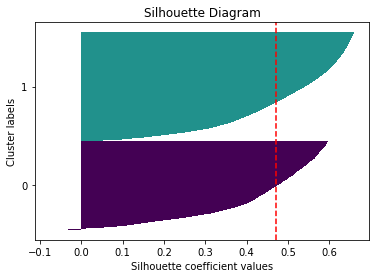

               age         fnlwgt  education-num  capital-gain  capital-loss  \
cluster                                                                        
0        43.739036  186932.334425      10.494509   2102.099311    132.662370   
1        34.357486  192109.409888       9.741732    238.572402     50.152905   

         hours-per-week  workclass_ ?  workclass_ Federal-gov  \
cluster                                                         
0             44.266216      0.034241                0.033422   
1             37.301508      0.074525                0.026257   

         workclass_ Local-gov  workclass_ Never-worked  ...  \
cluster                                                 ...   
0                    0.068890                 0.000000  ...   
1                    0.060503                 0.000391  ...   

         native-country_ Scotland  native-country_ South  \
cluster                                                    
0                        0.000273            

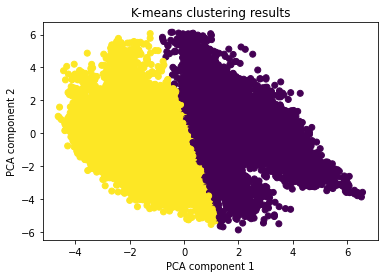

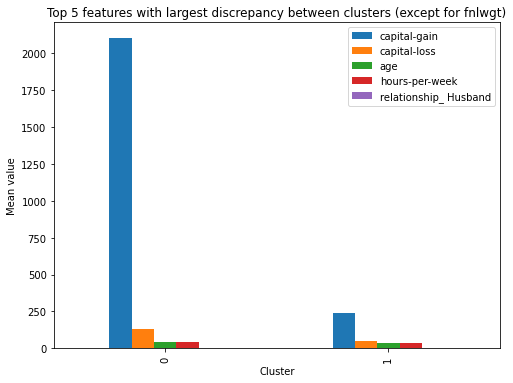

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,silhouette_samples

# Load the dataset into a pandas dataframe
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None, na_values=['?'])
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Remove any rows with missing values
df = df.dropna()

# Convert the income variable to a binary variable
#df['income'] = np.where(df['income'] == ' <=50K', 0, 1)

# Convert categorical variables to dummy variables
cat_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country','income']
df = pd.get_dummies(df, columns=cat_vars)

# Standardize the data
X = df#.drop('income', axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Calculate the distortion (inertia) for each k
distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

# Calculate the silhouette scores for different values of k
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    score = silhouette_score(X_pca, labels)
    print(f"Silhouette score for {k} clusters:", score)

# Apply K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_

# Calculate the silhouette score
score = silhouette_score(X_pca, labels)
print("Silhouette score for k=2:", score)

# Plot the silhouette diagram
silhouette_values = silhouette_samples(X_pca, labels)
y_lower, y_upper = 0, 0
yticks = []
for i, label in enumerate(np.unique(labels)):
    label_silhouette_values = silhouette_values[labels == label]
    label_silhouette_values.sort()
    y_upper += len(label_silhouette_values)
    color = plt.cm.viridis(float(i) / len(np.unique(labels)))
    plt.barh(range(y_lower, y_upper), label_silhouette_values, height=1.0, color=color)
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(label_silhouette_values)
silhouette_average = np.mean(silhouette_values)
plt.axvline(x=silhouette_average, color='red', linestyle='--')
plt.yticks(yticks, np.unique(labels))
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster labels')
plt.title('Silhouette Diagram')
plt.show()

# Interpret the clusters
df['cluster'] = labels
cluster_means = df.groupby('cluster').mean()
print(cluster_means)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('K-means clustering results')
plt.show()

# Calculate the difference in means between the clusters
diff_means = cluster_means.diff().iloc[1, :]

# Select the top 5 features with the largest discrepancy, except for the one with the largest discrepancy
top5 = diff_means.abs().nlargest(6).index
top5 = top5.drop(diff_means.abs().idxmax())

# Plot the mean values for the top 5 features, except for the one with the largest discrepancy
fig, ax = plt.subplots(figsize=(8, 6))
cluster_means[top5].plot(kind='bar', ax=ax)
ax.set_xlabel('Cluster')
ax.set_ylabel('Mean value')
ax.set_title('Top 5 features with largest discrepancy between clusters (except for fnlwgt)')
plt.show()